In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device=", device) 

device= cpu


In [3]:
au_path = './data/train/muff-input.wav'#'../data/ht1-input_train.wav'
train_sig, sr = torchaudio.load(au_path)
print(sr)

44100


In [4]:
tar_path = './data/train/muff-target.wav'#'../data/ht1-target_train.wav'
train_tar_sig, tar_sr = torchaudio.load(tar_path)
print(tar_sr)

44100


In [5]:
#len(train_input)
train_sig.shape
train_tar_sig.shape

torch.Size([1, 14994001])

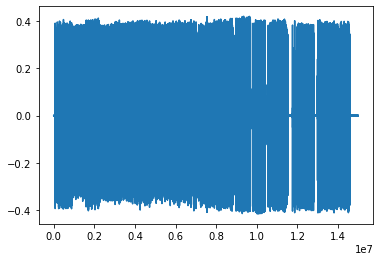

In [7]:
plt.plot(train_tar_sig.t().numpy())

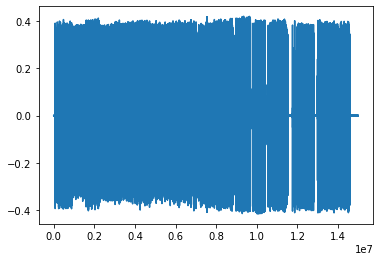

In [8]:
plt.plot(train_tar_sig.t().numpy())

### Do we need transform here? maybe not?

In [9]:
# # transform : downsample here 
# new_sr = 8000 #10000
# transform = transforms.Resample(orig_freq=sr, new_freq=new_sr)
# train_input = transform(sig)
# train_target = transform(tar_sig)
# ipd.Audio(train_input.numpy(), rate=new_sr)

In [11]:
train_input = train_sig[:,:44100*60]
train_target = train_tar_sig[:,:44100*60]

In [12]:
train_input.shape


torch.Size([1, 2646000])

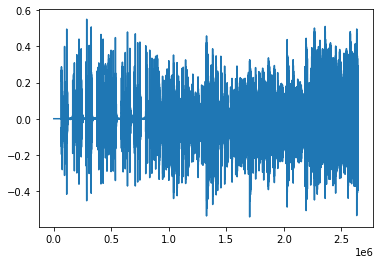

In [13]:
plt.plot(train_input.t().numpy())

In [13]:
#plt.plot(train_target.t().numpy())

# For Reproducibility

In [14]:
torch.manual_seed(0)

## Initialize Dataloader

In [15]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        #print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)


In [16]:
train_input.squeeze(0).shape

torch.Size([2646000])

In [18]:
batch_size = 1024
sequence_length = 512
train_dataset=DIIRDataSet(train_input.squeeze(0), train_target.squeeze(0), sequence_length)
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =True, pin_memory=True, drop_last=True) #? what does the shuffle really shuffles here?

torch.Size([5167, 1, 512])
torch.Size([5167, 1, 512])


In [19]:
len(loader)

5

# Declare Model

In [20]:
class MLP_BASE(Module): 
    def __init__(self, n_input=1, n_channel=32, n_output=1):
        super(MLP_BASE, self).__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(n_input, n_channel),
            nn.Tanh(),
            nn.Linear(n_channel, n_output),
        )
        
    def forward(self, x):
        return self.mlp_stack(x)
        

In [21]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=80, n_channel=32):
        super(FIRNN, self).__init__()
        self.conv_kz = kernel_size
        self.input_len = 512
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=kernel_size, stride=1)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(n_channel, n_channel*2, kernel_size=1) #nn.Linear(n_channel*self.input_len, n_channel)
        self.fc2 = nn.Conv1d(n_channel*2, n_output, kernel_size=1)
        #self.fc3 = nn.Conv1d(n_channel, n_output, kernel_size=1)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
#             nn.Tanh(),
#             self.fc3,
        )
        
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(n_channel*self.input_len, 64),
          nn.Tanh(),
          nn.Linear(64, n_output)
#           nn.Tanh(),
#           nn.Linear(32, 10)
        )

    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
    
        # first get fir output
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x) 
        #print(x.shape)
        x = self.nonlinear(self.bn1(x))
        #print(x.shape)

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape)

        return x


In [22]:
model = FIRNN(kernel_size=80, n_channel=32)

## Define optimizer and criterion

In [23]:
import torch.nn as nn
from torch.optim import Adam

n_epochs = 100
lr = 1e-3

#optimizer = Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) 
criterion = nn.MSELoss()

# Define train loop

In [24]:
def train(criterion, model, loader, optimizer):
    model.train()
    device = next(model.parameters()).device
    total_loss = 0
    
    for ind, batch in enumerate(loader):
        input_seq_batch = batch['input'].to(device)
        target_seq_batch = batch['target'].to(device)
        optimizer.zero_grad()
        predicted_output = model(input_seq_batch)
#         output = predicted_output.detach().cpu()
#         save_tensor = torch.cat([save_tensor, output], dim=0)
        #print(predicted_output.shape) #[1024,512,1]
        loss = criterion(target_seq_batch, predicted_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(loader)
    return total_loss

## Train!

In [25]:
for epoch in range(n_epochs):
    loss = train(criterion, model, loader, optimizer)
    scheduler.step()
    print("Epoch {} -- Loss {:3E}".format(epoch, loss))
    

Epoch 0 -- Loss 9.851143E-03
Epoch 1 -- Loss 2.892649E-03
Epoch 2 -- Loss 2.612672E-03
Epoch 3 -- Loss 2.265361E-03
Epoch 4 -- Loss 1.775539E-03
Epoch 5 -- Loss 1.814965E-03
Epoch 6 -- Loss 1.661792E-03
Epoch 7 -- Loss 1.612427E-03
Epoch 8 -- Loss 1.574669E-03
Epoch 9 -- Loss 1.544293E-03
Epoch 10 -- Loss 1.518121E-03
Epoch 11 -- Loss 1.497477E-03
Epoch 12 -- Loss 1.483232E-03
Epoch 13 -- Loss 1.470707E-03
Epoch 14 -- Loss 1.460157E-03
Epoch 15 -- Loss 1.451740E-03
Epoch 16 -- Loss 1.443043E-03
Epoch 17 -- Loss 1.438306E-03
Epoch 18 -- Loss 1.432519E-03
Epoch 19 -- Loss 1.426934E-03
Epoch 20 -- Loss 1.427459E-03
Epoch 21 -- Loss 1.423518E-03
Epoch 22 -- Loss 1.426634E-03
Epoch 23 -- Loss 1.423577E-03
Epoch 24 -- Loss 1.422252E-03
Epoch 25 -- Loss 1.421513E-03
Epoch 26 -- Loss 1.422668E-03
Epoch 27 -- Loss 1.421230E-03
Epoch 28 -- Loss 1.421938E-03
Epoch 29 -- Loss 1.420441E-03
Epoch 30 -- Loss 1.422046E-03
Epoch 31 -- Loss 1.420271E-03
Epoch 32 -- Loss 1.419871E-03
Epoch 33 -- Loss 1.4

# Evaluate

In [26]:
save_path = os.path.join('./models/model_muff1min_k80_1mlp2nlinear_bs1024_ch32_44khz_ep{}.pth'.format(n_epochs-1))
torch.save(model.state_dict(), save_path)

In [27]:
val_batch_size = 128
sequence_length = 512
val_dataset=DIIRDataSet(train_input.squeeze(0), train_target.squeeze(0), sequence_length)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, pin_memory=True, drop_last=True)

torch.Size([5167, 1, 512])
torch.Size([5167, 1, 512])


In [28]:
def inspect_file(path):
    print("-" * 10)
    print("Source:", path)
    print("-" * 10)
    print(f" - File size: {os.path.getsize(path)} bytes")
    print(f" - {torchaudio.info(path)}")

In [29]:
def save_audio(batch):
    #1024,512,1
    out_batch = batch.detach().cpu()
    out_batch = out_batch.squeeze(-1).flatten()
    print(out_batch.shape)
    return out_batch

In [30]:
import soundfile as sf

out_path = './output/'
sample_rate = 44100
save_tensor = torch.zeros(5167,512)
with torch.no_grad():
    for i, val_batch in enumerate(val_loader):
        input_seq_batch = val_batch['input'].to(device)
        #target_seq_batch = val_batch['target'].to(device)
        predicted_output = model(input_seq_batch)
        output_tmp = predicted_output.squeeze().detach().cpu()
        #print(output_tmp.shape)
        save_tensor[i,:] = output_tmp
    
    print(save_tensor.shape)
    out_audio = save_audio(save_tensor)
    print(out_audio.shape)
    path = os.path.join(out_path, "target_muff1min_firk80model_1mlp2nlinear_bs1024_ch32_44khz_optchg.wav")
    print("Exporting {}".format(path))
    sf.write(path, out_audio, sample_rate,'PCM_24')
    #torchaudio.save(path, out_audio, sample_rate, encoding="PCM_S", bits_per_sample=16)
    inspect_file(path)
    

torch.Size([5167, 512])
torch.Size([2645504])
torch.Size([2645504])
Exporting ./output/target_muff1min_firk80model_1mlp2nlinear_bs512_ch32_44khz_optchg.wav
----------
Source: ./output/target_muff1min_firk80model_1mlp2nlinear_bs512_ch32_44khz_optchg.wav
----------
 - File size: 7936556 bytes
 - AudioMetaData(sample_rate=44100, num_frames=2645504, num_channels=1, bits_per_sample=24, encoding=PCM_S)


In [7]:
# #small test on padding
# t4d = torch.ones(3, 3, 4)
# print(t4d.shape)
# out = F.pad(t4d, (3,0)) #"constant", 0
# print(out.shape)

torch.Size([3, 3, 4])
torch.Size([3, 3, 7])


In [8]:
t4d[1,1,:]

tensor([1., 1., 1., 1.])

In [9]:
out[1,1,:]

tensor([0., 0., 0., 1., 1., 1., 1.])